## Задача

Мы в компании работаем над  повышением лояльности клиентов. В датасете представлен один рабочий день пиццерии. Расскажите, что происходило в этот день. Подумайте, как можно повысить лояльность клиентов. 
Дайте знать, если вам не хватает данных, и что бы вы добавили и еще проанализировали.

#### Столбцы таблицы продуктов

- Начали принимать заказ — время начала приема заказа;
- Закончили принимать заказ — время окончания приема заказа;
- Повезли клиенту / выдали в руки – время, когда заказ был упакован и передан курьеру или клиенту в ресторане;
- OrderId — идентификатор заказа;
- OrderType – тип продажи. Заказы могут быть проданы в ресторане и отвезены на доставку;
- ProductId — идентификатор продукта;
- ProductPrice – цена продукта;
- CategoryId — категория продукта;
- ClientId — идентификатор клиента;
- IsBaked — признак выпекаемый ли продукт;
 
Вспомогательные данные:

- CategoryId == 1, ‘Пицца’,
- CategoryId == 2, ‘Напитки’,
- CategoryId == 3, ‘Закуски’,
- CategoryId == 4, ‘Соусы’,
- CategoryId == 5, ‘Товары’,
- CategoryId == 6, ‘Десерты’,
- CategoryId == 7, ‘Кусочки пиццы’

## Решение

#### Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [2]:
init_df = pd.read_csv('dodo.csv')

In [3]:
init_df.head()

,OrderId,OrderType,Начали принимать заказ,Закончили принимать заказ,Повезли клиенту / выдали в руки,ProductId,CategoryId,IsBaked,ProductPrice,ClientId
0,642591840,Restaurant,10:57:28,10:57:55,11:10:09,10089,2,0,99,NaN
1,642544012,Restaurant,9:49:08,9:49:24,9:55:37,42633,7,1,49,NaN
2,642538752,Delivery,9:37:44,9:37:44,9:57:29,18,0,0,432,1980008.0
3,642541564,Restaurant,9:43:21,9:44:23,9:58:36,2016,2,0,75,13481466.0
4,642620880,Delivery,11:25:20,11:25:20,11:47:50,81,1,1,579,25936257.0


In [4]:
init_df.shape

(4346, 10)

In [5]:
init_df.dtypes

OrderId                              int64
OrderType                           object
Начали принимать заказ              object
Закончили принимать заказ           object
Повезли клиенту / выдали в руки     object
ProductId                            int64
CategoryId                           int64
IsBaked                              int64
ProductPrice                         int64
ClientId                           float64
dtype: object

In [6]:
init_df.rename(columns = {'Начали принимать заказ':'order_start',
                          'Закончили принимать заказ':'order_end',
                          'Повезли клиенту / выдали в руки':'to_delivery'},
              inplace = True)

In [7]:
init_df.head()

,OrderId,OrderType,order_start,order_end,to_delivery,ProductId,CategoryId,IsBaked,ProductPrice,ClientId
0,642591840,Restaurant,10:57:28,10:57:55,11:10:09,10089,2,0,99,NaN
1,642544012,Restaurant,9:49:08,9:49:24,9:55:37,42633,7,1,49,NaN
2,642538752,Delivery,9:37:44,9:37:44,9:57:29,18,0,0,432,1980008.0
3,642541564,Restaurant,9:43:21,9:44:23,9:58:36,2016,2,0,75,13481466.0
4,642620880,Delivery,11:25:20,11:25:20,11:47:50,81,1,1,579,25936257.0


In [8]:
# Переведем время в соответствующий формат

init_df['order_start'] = pd.to_datetime(init_df['order_start'])
init_df['order_end'] = pd.to_datetime(init_df['order_end'])
init_df['to_delivery'] = pd.to_datetime(init_df['to_delivery'])

In [9]:
# Посчитаем время от заказа до выдачи

init_df['delta'] = (init_df['to_delivery']-init_df['order_end']).dt.seconds

# Приведем время старта заказа к началу часу

init_df['order_start_h'] = init_df['order_start'].dt.hour

In [10]:
# В разбивке ресторан/доставка

init_df.groupby('OrderType', as_index = False) \
    .agg({'OrderId':'nunique', 'ProductPrice':'sum', 'ClientId':'nunique'})\
    .rename(columns = {'OrderId':'Orders_qnt', 'ProductPrice':'Sum', 'ClientId':'Unique_identified_clients'})

,OrderType,Orders_qnt,Sum,Unique_identified_clients
0,Delivery,394,688190,388
1,Restaurant,497,352090,84


#### Анализ

План
- Как меняется выручка в течение дня
- Как на выручку влияет трафик посетителей и средний чек/ARPPU
- Как меняется время от заказа до передачи в доставку/в руки клиенту в течение дня?

- Есть ли разница в средних чеках у зарегистрированных и не зарегистрированных пользователей
- В какой момент дня чеки больше?
- Как влияет наличие выпекаемого продукта в заказе на время ожидания?

In [12]:
# Посчитаем суммы чеков

checks = init_df.groupby('OrderId', as_index = False).agg({'ClientId':'min',
                                                           'OrderType':'min',
                                                           'ProductPrice':'sum',
                                                          'order_start_h':'min',
                                                          'delta':'min',
                                                           'ProductId':['nunique', 'count'],
                                                          'CategoryId':['nunique', 'count'],
                                                          'IsBaked':'sum'})

checks.sort_values(('order_start_h', 'min')).head()

OrderId    ClientId OrderType ProductPrice order_start_h  delta  \
                     min       min          sum           min    min   
0  642483792  10925942.0  Delivery         2008             4  45916   
1  642494272  31799916.0  Delivery         3265             6  40699   
2  642499600  10445007.0  Delivery         4031             7  12072   
3  642502104   1644383.0  Delivery         1362             7   6155   
4  642505632  17686181.0  Delivery         2048             7   4998   

  ProductId       CategoryId       IsBaked  
    nunique count    nunique count     sum  
0         4     7          3     7       3  
1         4     6          3     6       3  
2         7    11          3    11       7  
3         4     5          3     5       3  
4         5     8          3     8       2

In [13]:
columns = []
for x in range(len(checks.columns)):
    columns.append(checks.columns[x][0] + '_' + checks.columns[x][1])

In [14]:
columns = ['OrderId',
           'ClientId',
 'OrderType',
 'check_sum',
 'hour_start',
 'delta_min',
 'items_unique',
 'items_tot',
 'cat_unique',
 'cat_tot',
 'baked_items']

In [16]:
a = pd.to_datetime(checks.hour_start, format = '%H')

checks['time'] = a

In [15]:
checks.columns = columns
checks.sort_values('hour_start', inplace = True)
checks.head()

,OrderId,ClientId,OrderType,check_sum,hour_start,delta_min,items_unique,items_tot,cat_unique,cat_tot,baked_items
0,642483792,10925942.0,Delivery,2008,4,45916,4,7,3,7,3
1,642494272,31799916.0,Delivery,3265,6,40699,4,6,3,6,3
2,642499600,10445007.0,Delivery,4031,7,12072,7,11,3,11,7
3,642502104,1644383.0,Delivery,1362,7,6155,4,5,3,5,3
4,642505632,17686181.0,Delivery,2048,7,4998,5,8,3,8,2


In [11]:
#Кто из клиентов совершил несколько заказов?

mult_orders = init_df.query('OrderType == "Delivery"') \
            .groupby('ClientId') \
            .OrderId.nunique() \
            .sort_values(ascending = False) \
            .index.to_list()[0:4]

mult_orders

[44364464.0, 32371307.0, 28941958.0, 23612117.0]

In [19]:
checks.loc[checks['ClientId'].isin(mult_orders)].sort_values('ClientId')

,OrderId,ClientId,OrderType,check_sum,hour_start,delta_min,items_unique,items_tot,cat_unique,cat_tot,baked_items,time
180,642659188,23612117.0,Delivery,607,11,323,3,7,2,7,0,1900-01-01 11:00:00
178,642658020,23612117.0,Delivery,508,11,1261,3,3,2,3,1,1900-01-01 11:00:00
341,642829972,28941958.0,Delivery,1868,13,15630,3,5,3,5,2,1900-01-01 13:00:00
401,642916372,28941958.0,Delivery,1319,14,12350,5,7,4,7,3,1900-01-01 14:00:00
889,643641448,32371307.0,Delivery,589,23,544,2,2,2,2,1,1900-01-01 23:00:00
888,643640780,32371307.0,Delivery,1268,23,747,2,3,3,3,1,1900-01-01 23:00:00
474,643015464,44364464.0,Delivery,609,15,3070,3,4,3,4,1,1900-01-01 15:00:00
479,643020644,44364464.0,Delivery,1408,15,2869,2,3,3,3,1,1900-01-01 15:00:00
485,643023516,44364464.0,Delivery,759,15,2767,2,2,2,2,1,1900-01-01 15:00:00
487,643026060,44364464.0,Delivery,1408,15,2660,2,3,3,3,1,1900-01-01 15:00:00


Так как большинство клиентов офф-лайн пиццерии не принадлежат программе лояльности, а повторных он-лайн заказов незначительное количество* в качестве показателя будем использовать средний счет, а не ARPPU.

*множественные заказы у клиентов проходили примерно в одно и то же время, возможно, заказы отменялись и делались вновь - необходимо проверить логи оплаты

## Показатели пиццерии

In [358]:
b = checks.set_index('time')

In [359]:
b.groupby('OrderType').agg({'check_sum':['sum','mean', 'median', 'count']})

check_sum                           
                 sum         mean  median count
OrderType                                      
Delivery      688190  1746.675127  1487.5   394
Restaurant    352090   708.430584   397.0   497

In [360]:
# Определим функцию для подсчита скользящих средних

def rolling_average(df = b, col = 'check_sum', func = 'mean'):
    d = df.query('OrderType == "Delivery"').rolling('3h')[col].__getattribute__(func)().reset_index().drop_duplicates('time', keep = 'last')
    r = df.query('OrderType == "Restaurant"').rolling('3h')[col].__getattribute__(func)().reset_index().drop_duplicates('time', keep = 'last')    
    return d, r

In [361]:
# Определим функцию для отрисовки графиков

def plot(title, col = 'check_sum', df_delivery = d, df_rest = r):
    plt.figure(figsize=(10,4))
    sns.lineplot(x = df_delivery.time.dt.hour, y = df_delivery[col], label = 'Delivery').set(title = title)
    sns.lineplot(x = df_rest.time.dt.hour, y = df_rest[col], label = 'Restaurant')
    plt.grid()
    plt.xticks([x for x in range(5,24, 2)])  
    plt.show()

#### Динамика выручки

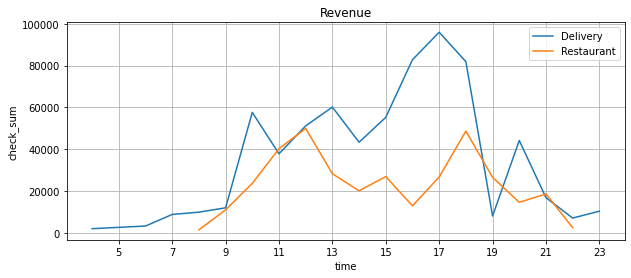

In [362]:
d = b.query('OrderType == "Delivery"').groupby('time').check_sum.sum().reset_index()
r = b.query('OrderType == "Restaurant"').groupby('time').check_sum.sum().reset_index()

plot('Revenue', 'check_sum', d, r)

Что бы лучше понимать тренды метрик, будем отрисовывать скользящие показатели

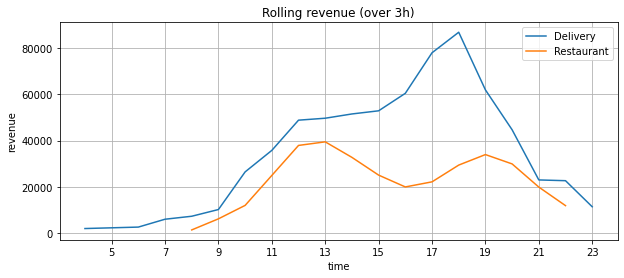

In [363]:
b1 = b.groupby(['OrderType', 'time']).check_sum.sum().reset_index().rename(columns = {'check_sum':'revenue'})

d, r = rolling_average(df = b1.set_index('time'), col = 'revenue', func = 'mean')

plot('Rolling revenue (over 3h)', 'revenue', d,r)

####  Динамика среднего чека

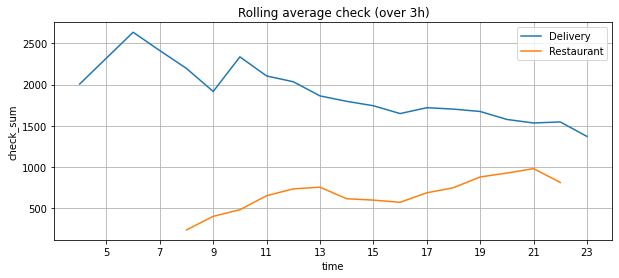

In [364]:
d, r = rolling_average(col = 'check_sum', func = 'mean')
plot('Rolling average check (over 3h)', 'check_sum', d, r)

###### Динамика медианного чека

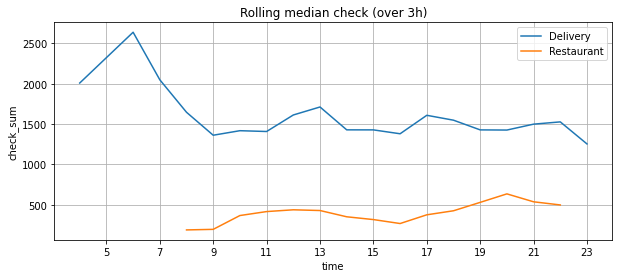

In [365]:
d, r = rolling_average(col = 'check_sum', func = 'median')
plot('Rolling median check (over 3h)', 'check_sum', d, r)

#### Динамика количества заказов

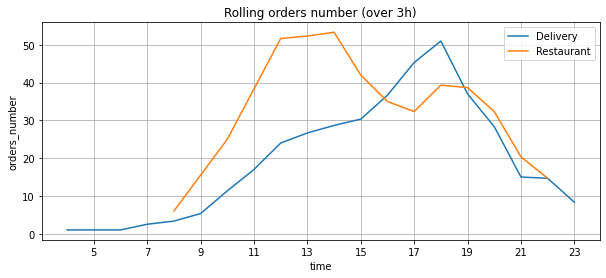

In [366]:
b1 = b.groupby(['OrderType', 'time']).check_sum.count().reset_index().rename(columns = {'check_sum':'orders_number'})
d, r = rolling_average(df = b1.set_index('time'), col = 'orders_number', func = 'mean')

plot('Rolling orders number (over 3h)', 'orders_number', d, r)

#### Динамика времени ожидания

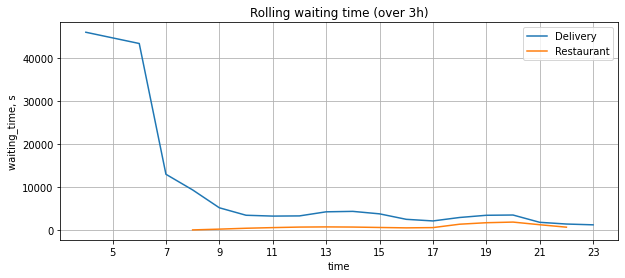

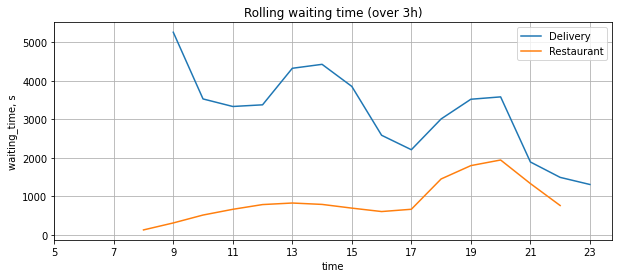

In [302]:
r = b.query('OrderType == "Restaurant"').rolling('3h').delta_min.mean().reset_index().rename(columns = {'delta_min':'waiting_time, s'}).drop_duplicates('time', keep = 'last')
d = b.query('OrderType == "Delivery"').rolling('3h').delta_min.mean().reset_index().rename(columns = {'delta_min':'waiting_time, s'}).drop_duplicates('time', keep = 'last')

plot('Rolling waiting time (over 3h)', 'waiting_time, s', d, r)
plot('Rolling waiting time (over 3h)', 'waiting_time, s', d.query('time.dt.hour > 8'), r)

#### Перцентили для чеков

In [ ]:
# Функции для подсчета перцентилей
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def rename(k, allias):
    if k in ['OrderType', 'hour_start']:
        return k
    else:
        return allias + '_' + k

# Подсчет перцентилей по чекам
checks_perc = checks.groupby(['OrderType', 'hour_start'], as_index = False).check_sum \
                    .agg(['mean', 'min', percentile(10), percentile(20), percentile(30),
                          percentile(40), percentile(50), percentile(60),
                          percentile(70), percentile(80), percentile(90),'max', 'sum']) \
                    .reset_index() \
                    .rename(columns = lambda s: rename(s, 'check'))

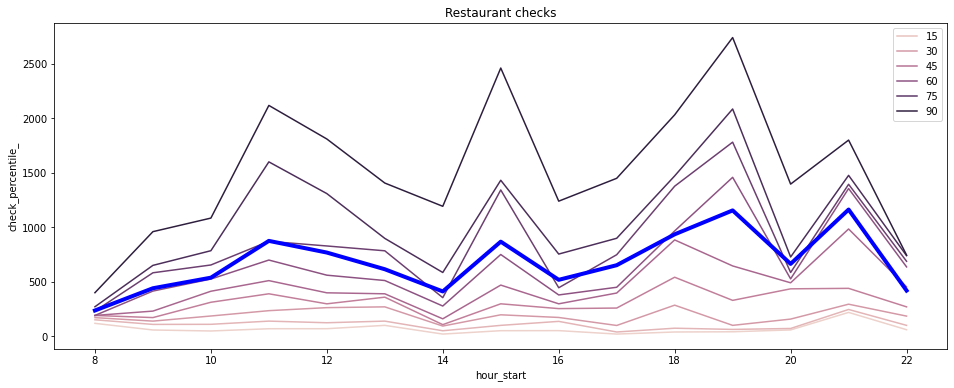

In [396]:
r = pd.wide_to_long(checks_perc, stubnames='check_percentile_', i=['OrderType', 'hour_start'], j='percentile').reset_index()
plt.figure(figsize=(16,6))
sns.lineplot(data = r.query('OrderType == "Restaurant" '), x = 'hour_start', y = 'check_percentile_', hue = 'percentile').set(title = 'Restaurant checks')
sns.lineplot(data = r.query('OrderType == "Restaurant"'), x = 'hour_start', y = 'check_mean', linewidth=4, color = 'blue')

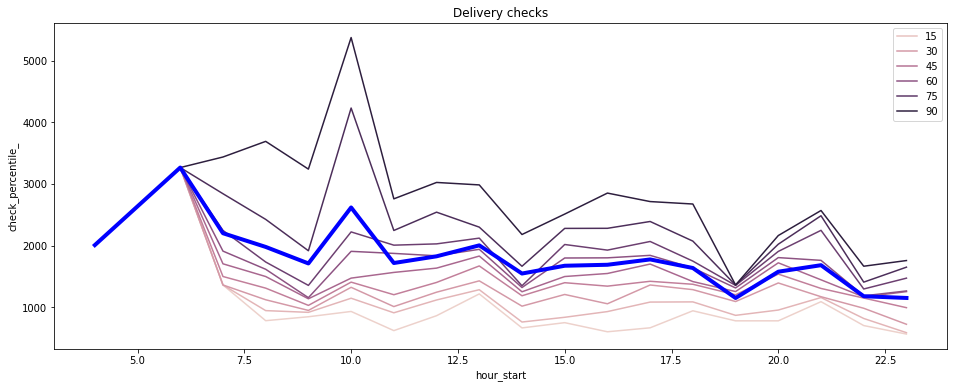

In [400]:

plt.figure(figsize=(16,6))
sns.lineplot(data = r.query('OrderType == "Delivery"'), x = 'hour_start', y = 'check_percentile_', hue = 'percentile')
sns.lineplot(data = r.query('OrderType == "Delivery"'), x = 'hour_start', y = 'check_mean', linewidth=4, color = 'blue').set(title = 'Delivery checks');

#### Время до выдачи офф-лайн клиентам в зависимости от аличия выпекаемой продукции

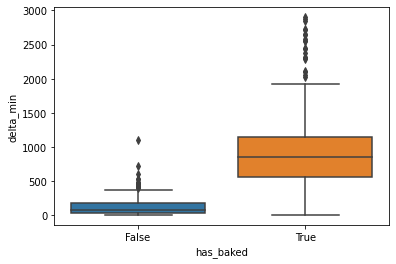

In [401]:
checks['has_baked'] = checks.baked_items > 0
sns.boxplot(data = checks.query('OrderType == "Restaurant" & delta_min < 3000'), y = 'delta_min', x = 'has_baked')

### Сравнение заказов зарегистрированных и незарегистрированных офф-лайн покупателей

In [403]:
checks['User_Idied'] = checks.ClientId.isna()

b2 = checks.query('OrderType == "Restaurant"').set_index('time')
b2.groupby('User_Idied').agg({'check_sum':['sum','mean','median'], 'OrderId':'count',})

check_sum                     OrderId
                 sum         mean median   count
User_Idied                                      
False         104297  1171.876404  899.0      89
True          247793   607.335784  334.5     408

In [388]:
89/(408+89)

0.1790744466800805

In [389]:
def rolling_average_id(df = b2, col = 'check_sum', func = 'mean'):
    i = df.query('User_Idied == True').rolling('3h')[col].__getattribute__(func)().reset_index().drop_duplicates('time', keep = 'last')
    n = df.query('User_Idied == False').rolling('3h')[col].__getattribute__(func)().reset_index().drop_duplicates('time', keep = 'last')    
    return i, n

def plot_id(title, col = 'check_sum', df_Id = i, df_nId = n):
    plt.figure(figsize=(10,4))
    sns.lineplot(x = df_Id.time.dt.hour, y = df_Id[col], label = 'Identified').set(title = title)
    sns.lineplot(x = df_nId.time.dt.hour, y = df_nId[col], label = 'not Identified')
    plt.grid()
    plt.xticks([x for x in range(5,24, 2)])  
    plt.show()

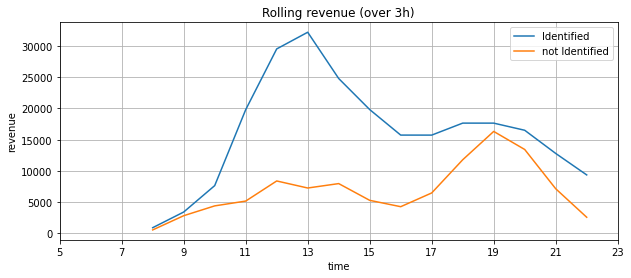

In [393]:
b4 = b2.reset_index().groupby(['User_Idied', 'time']).check_sum.sum().reset_index().rename(columns = {'check_sum':'revenue'})

i, n = rolling_average_id(df = b4.set_index('time'), col = 'revenue', func = 'mean')

plot_id('Rolling revenue', 'revenue', i,n)

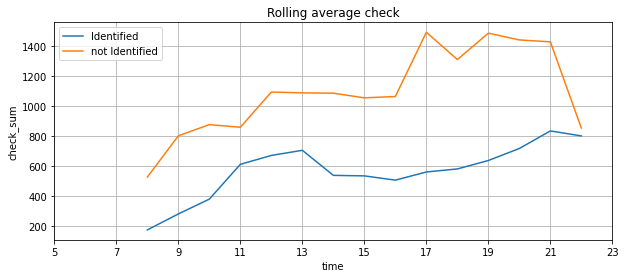

In [390]:
i, n = rolling_average_id()
plot_id('Rolling average check', 'check_sum', i, n)

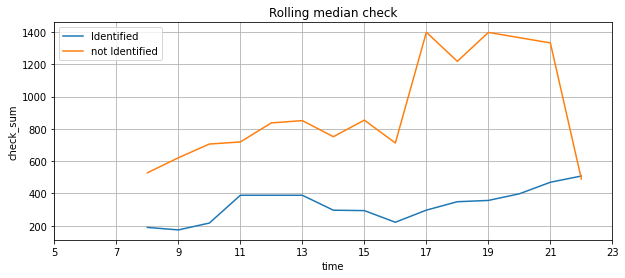

In [391]:
i, n = rolling_average_id(func = 'median')
plot_id('Rolling median check', 'check_sum', i, n)

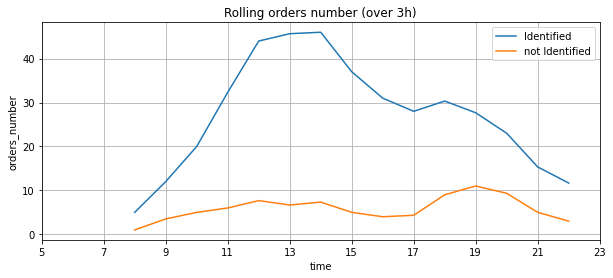

In [392]:
b3 = b2.reset_index().groupby(['User_Idied', 'time']).check_sum.count().reset_index().rename(columns = {'check_sum':'orders_number'})
i, n = rolling_average_id(df = b3.set_index('time'), col = 'orders_number', func = 'mean')

plot_id('Rolling orders number (over 3h)', 'orders_number', i, n)